# Mouse chimeras - differential analysis design

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import scvelo.datasets

import milopy
import scipy

import q2r_uncertainty.utils
import q2r_uncertainty.q2r_simulation
from q2r_uncertainty.train_models.train_scVI import _train_model,_fit_model

Global seed set to 0


In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns
import matplotlib

In [4]:
import diff2atlas

In [5]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import anndata2ri
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [234]:
%%R
library(tidyverse)
library(patchwork)

In [36]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

## Load integrated objects 

In [7]:
data_dir = '/home/jovyan/mount/gdrive/query2reference/mouse_gastrulation/'
pa_design_adata = sc.read_h5ad(data_dir + 'PA_design_coembedding.h5ad', backed='r')
pc_design_adata = sc.read_h5ad(data_dir + 'PC_design_coembedding.h5ad', backed='r')
pac_design_adata = sc.read_h5ad(data_dir + 'PAC_design_query.h5ad', backed='r')

In [8]:
def _rename_design(pac_design_adata):
    tomato_names = ['_tomatoP' if x == 1 else '_tomatoN' if x == 0 else '' for x in  pac_design_adata.obs['tomato']] 
    dataset_names = [x[0] for x in pac_design_adata.obs['sample'].str.split('_')]
    pac_design_adata.obs['design'] = list(map(''.join,zip(dataset_names, tomato_names)))

_rename_design(pac_design_adata)
_rename_design(pa_design_adata)
_rename_design(pc_design_adata)

## Prepare mapping confidence metric

In [11]:
pac_design_adata.obs['conf_score'] = 1 - pac_design_adata.obs['scArches_unc']
pc_design_adata.obs['conf_score'] = 1 - pc_design_adata.obs['scArches_unc']
pa_design_adata.obs['conf_score'] = 1 - pa_design_adata.obs['scArches_unc']

## Make neighbourhoods

In [16]:
## Make KNN graph with the same K for all
n_neighbors = 100
sc.pp.neighbors(pac_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)
sc.pp.neighbors(pa_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)
sc.pp.neighbors(pc_design_adata, use_rep='X_scVI', n_neighbors=n_neighbors)

In [ ]:
milopy.core.make_nhoods(pac_design_adata, prop=0.1)
milopy.core.make_nhoods(pa_design_adata, prop=0.1)
milopy.core.make_nhoods(pc_design_adata, prop=0.1)

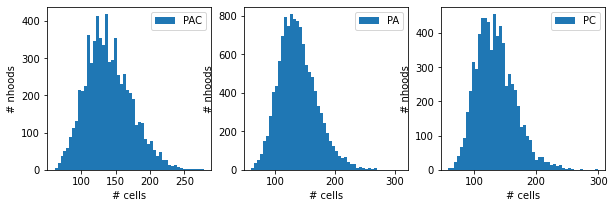

In [27]:
with rc_context({'figure.figsize':[10,3]}):
    plt.subplot(1,3,1);
    _plot_nhood_sizes(pac_design_adata, label='PAC');
    plt.legend()
    plt.subplot(1,3,2);
    _plot_nhood_sizes(pa_design_adata, label='PA');
    plt.legend()
    plt.subplot(1,3,3);
    _plot_nhood_sizes(pc_design_adata, label='PC');
    plt.legend()

Try making nhoods with overclustering (to overcome missing values problem)

In [404]:
# ...

## Store nhood confidence

In [405]:
diff2atlas.nhood_confidence(pac_design_adata, confidence_col='conf_score', sample_col='sample', impute_missing=False)
diff2atlas.nhood_confidence(pa_design_adata, confidence_col='conf_score', sample_col='sample', impute_missing=False)
diff2atlas.nhood_confidence(pc_design_adata, confidence_col='conf_score', sample_col='sample', impute_missing=False)

In [392]:
## Compute mean confidence for KO cells 
# get_nhood_adata(pac_design_adata)
def get_mean_confidence_x_nhood(adata, obs_names, confidence_col = 'conf_score'):
    '''
    Compute average confidence per neighbourhood using a subset of cells
    '''
    nhood_mat = adata[obs_names].obsm['nhoods']
    mean_conf_nhoods = nhood_mat.T.dot(
            scipy.sparse.csr_matrix(adata.obs.loc[obs_names, confidence_col]).T)
    mean_conf_nhoods = mean_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
    mean_conf_nhoods = np.nan_to_num(mean_conf_nhoods, 0) ## zero confidence where we have no cells
    return(mean_conf_nhoods)


get_nhood_adata(pac_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pac_design_adata, obs_names = pac_design_adata.obs_names[pac_design_adata.obs.design == 'Tal1Chimera_tomatoP'])
get_nhood_adata(pa_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pa_design_adata, obs_names = pa_design_adata.obs_names[pa_design_adata.obs.design == 'Tal1Chimera_tomatoP'])
get_nhood_adata(pc_design_adata).obs['conf_score_KO'] = get_mean_confidence_x_nhood(
    pc_design_adata, obs_names = pc_design_adata.obs_names[pc_design_adata.obs.design == 'Tal1Chimera_tomatoP'])

### Annotate neighbourhoods
Using labels from control samples

In [393]:
milopy.utils.annotate_nhoods(pac_design_adata[~pac_design_adata.obs_names.str.startswith("Tal1")], 'celltype.mapped')
milopy.utils.annotate_nhoods(pa_design_adata[~pa_design_adata.obs_names.str.startswith("Tal1")], 'celltype')
milopy.utils.annotate_nhoods(pc_design_adata[~pc_design_adata.obs_names.str.startswith("Tal1")], 'celltype.mapped')

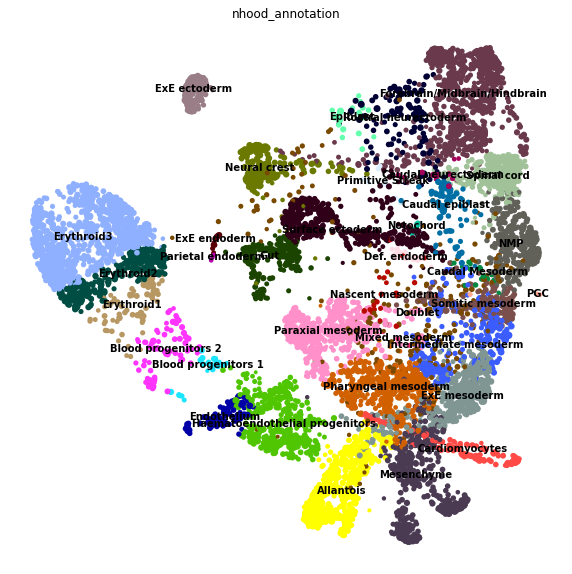

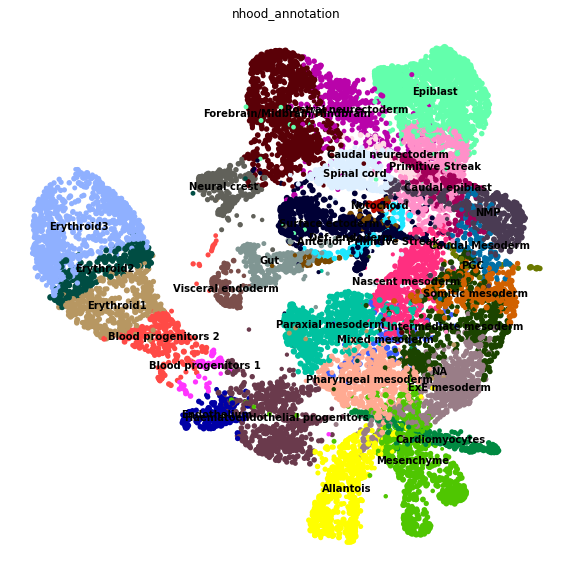

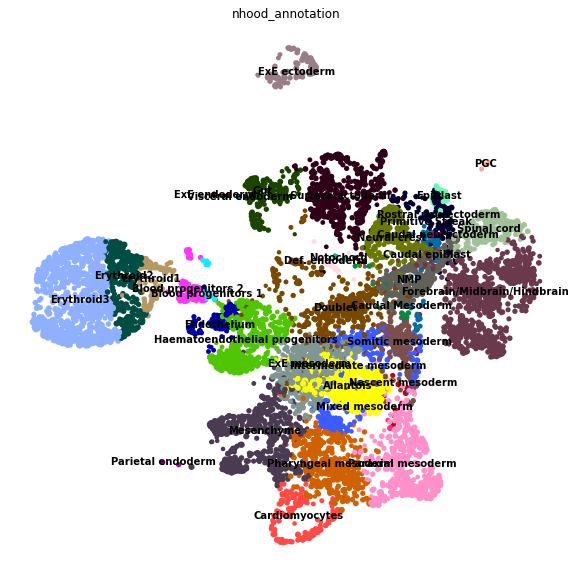

In [76]:
with rc_context({'figure.figsize':[10,10]}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(pa_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(pc_design_adata, min_size=1, color='nhood_annotation', legend_loc='on data')

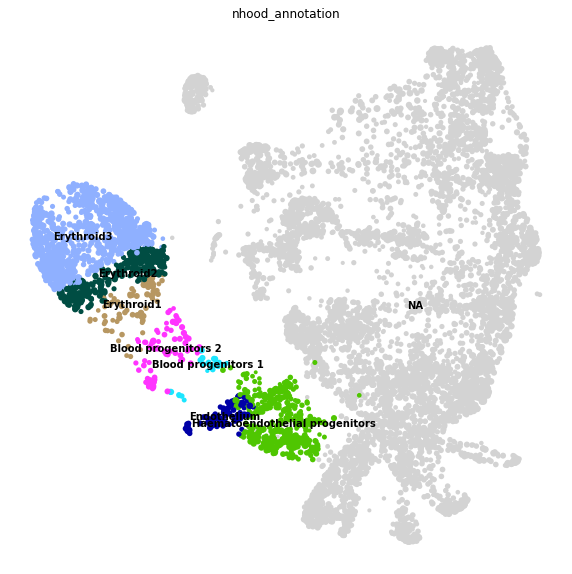

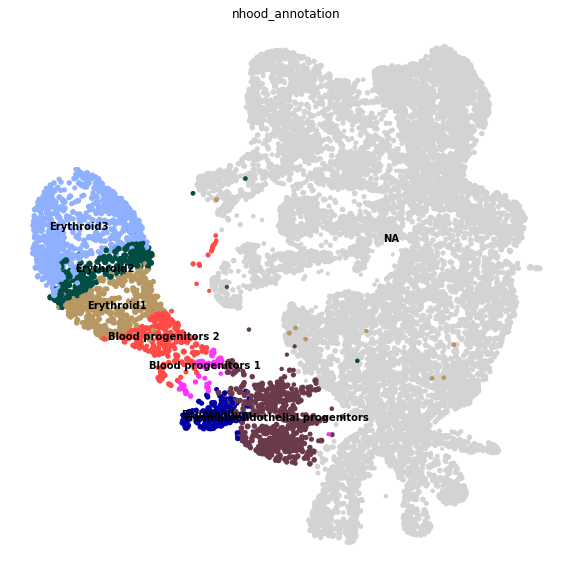

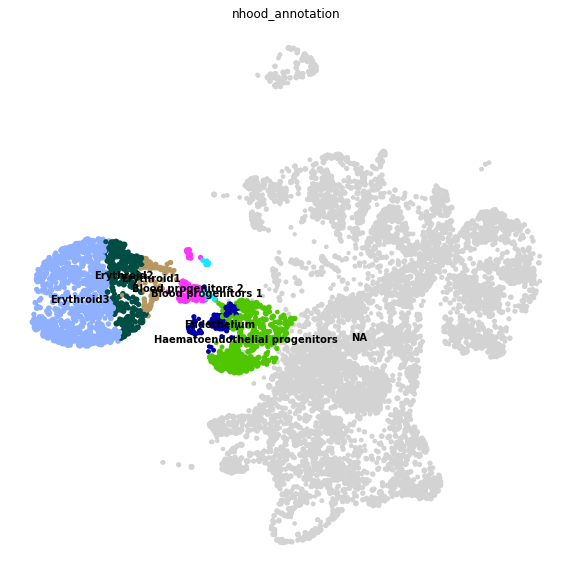

In [94]:
## Check interesting populations 
blood_lineages = [x for x in pa_design_adata.obs['celltype'].dropna().unique() if 'lood' in x or 'Erythroid' in x]
hema_endo_lineages = ['Haematoendothelial progenitors', 'Endothelium']

with rc_context({'figure.figsize':[10,10]}):
    diff2atlas.plotting.plot_nhood_graph(
        pac_design_adata, min_size=1, color='nhood_annotation', groups=blood_lineages + ['Haematoendothelial progenitors', 'Endothelium'], legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(
        pa_design_adata, min_size=1, color='nhood_annotation', groups=blood_lineages + ['Haematoendothelial progenitors', 'Endothelium'], legend_loc='on data')
    diff2atlas.plotting.plot_nhood_graph(
        pc_design_adata, min_size=1, color='nhood_annotation', groups=blood_lineages + ['Haematoendothelial progenitors', 'Endothelium'], legend_loc='on data')

## Compute DA logFC per neighbourhood

In [113]:
import milopy

In [386]:
pac_design_adata.obs['is_KO'] = pac_design_adata.obs['design'] == 'Tal1Chimera_tomatoP'
pc_design_adata.obs['is_KO'] = pc_design_adata.obs['design'] == 'Tal1Chimera_tomatoP'
pa_design_adata.obs['is_KO'] = pa_design_adata.obs['design'] == 'Tal1Chimera_tomatoP'

In [387]:
## Exclude WT cells in Tal1Chimera
PvsC_samples = pac_design_adata[pac_design_adata.obs['design'] != 'Tal1Chimera_tomatoN'].obs['sample'].unique().tolist()
PvsA_samples = pa_design_adata[pa_design_adata.obs['design'] != 'Tal1Chimera_tomatoN'].obs['sample'].unique().tolist()

milopy.core.DA_nhoods(pac_design_adata, design='~ is_KO', 
                      subset_samples=PvsC_samples)
milopy.core.DA_nhoods(pc_design_adata, design='~ is_KO', 
                      subset_samples=PvsC_samples)
milopy.core.DA_nhoods(pa_design_adata, design='~ is_KO', 
                      subset_samples=PvsA_samples)

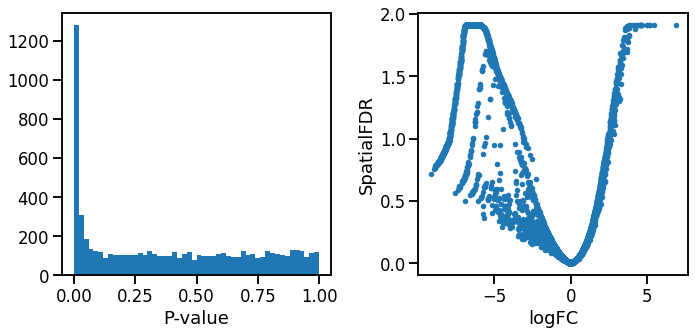

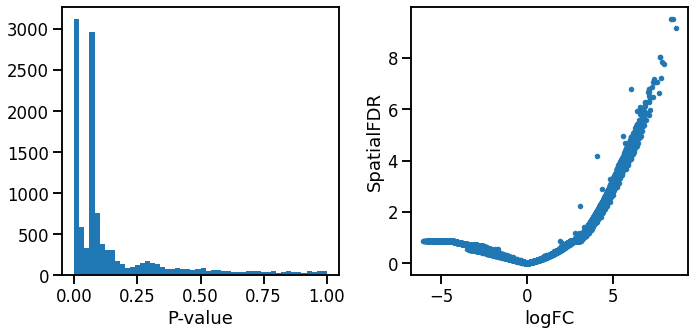

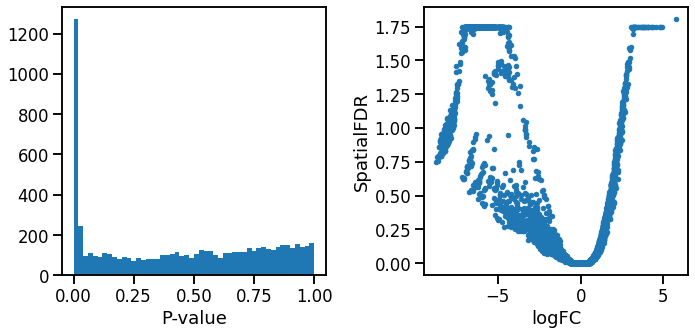

In [388]:
def plot_DA_checks(pac_design_adata):
    lfc = get_nhood_adata(pac_design_adata).obs['logFC']
    FDR_perc = -np.log10(get_nhood_adata(pac_design_adata).obs['SpatialFDR'])
    pvals = get_nhood_adata(pac_design_adata).obs['PValue']
    plt.subplot(1,2,1);
    plt.hist(pvals, bins=50);
    plt.xlabel('P-value');
    plt.subplot(1,2,2);
    plt.plot(lfc, FDR_perc, '.');
    plt.ylabel('SpatialFDR');
    plt.xlabel('logFC');
    plt.tight_layout();
    plt.show()

sns.set_context('talk');
with rc_context({'figure.figsize':[10,5]}):
    plot_DA_checks(pac_design_adata)
    plot_DA_checks(pa_design_adata)
    plot_DA_checks(pc_design_adata)

In [389]:
milopy.utils.build_nhood_graph(pac_design_adata)
milopy.utils.build_nhood_graph(pc_design_adata)
milopy.utils.build_nhood_graph(pa_design_adata)

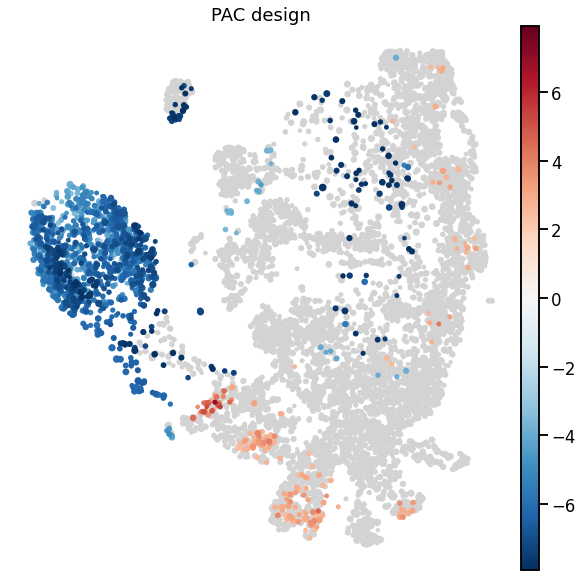

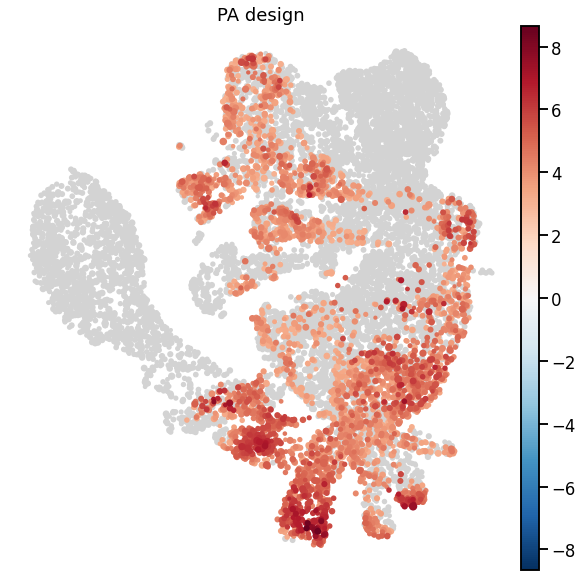

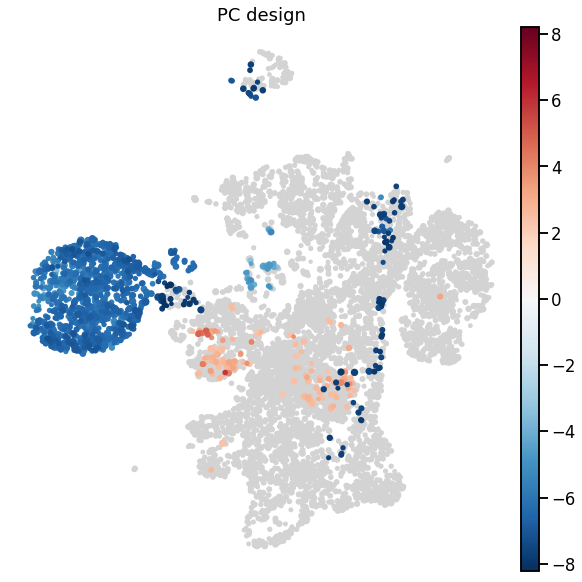

In [390]:
with rc_context({'figure.figsize':[10,10]}):
    milopy.plot.plot_nhood_graph(pac_design_adata, min_size=1, title='PAC design')
    milopy.plot.plot_nhood_graph(pa_design_adata, min_size=1, title='PA design')
    milopy.plot.plot_nhood_graph(pc_design_adata, min_size=1, title='PC design')


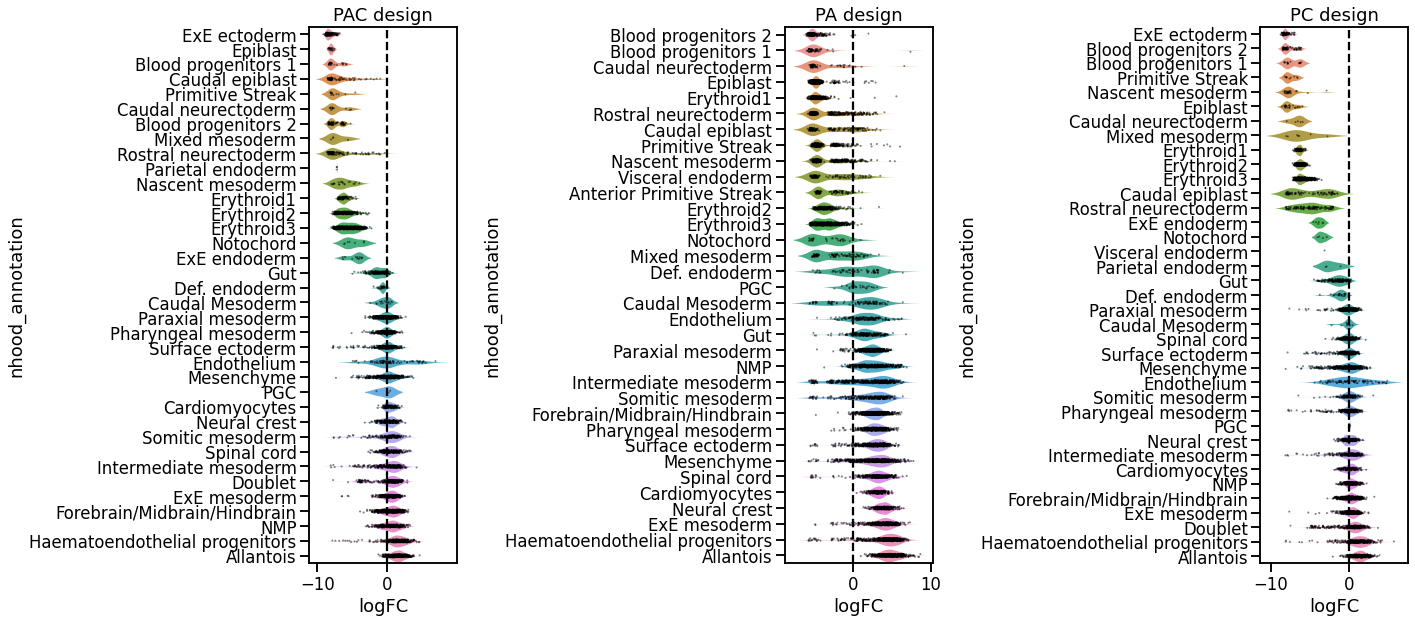

In [1008]:
with rc_context({'figure.figsize':[20,9]}):
    plt.subplot(1,3,1);
    milopy.plot.plot_DA_beeswarm(pac_design_adata);
    plt.title('PAC design');
    plt.subplot(1,3,2);
    milopy.plot.plot_DA_beeswarm(pa_design_adata);
    plt.title('PA design');
    plt.subplot(1,3,3);
    milopy.plot.plot_DA_beeswarm(pc_design_adata);
    plt.title('PC design');
    plt.tight_layout()

In [ ]:
def get_signif_nhoods(adata, alpha=0.1):
    try:
        nhood_adata = adata.uns["nhood_adata"].copy()
    except KeyError:
        raise KeyError(
                'Cannot find "nhood_adata" slot in adata.uns -- please run milopy.make_nhoods_adata(adata)'
            )
    return(nhood_adata.obs_names[nhood_adata.obs['SpatialFDR'] < alpha])

with rc_context({'figure.figsize':[20,9]}):
    plt.subplot(1,3,1);
    milopy.plot.plot_DA_beeswarm(pac_design_adata, subset_nhoods=get_signif_nhoods(pac_design_adata));
    plt.title('PAC design');
    plt.subplot(1,3,2);
    milopy.plot.plot_DA_beeswarm(pa_design_adata, subset_nhoods=get_signif_nhoods(pa_design_adata));
    plt.title('PA design');
    plt.subplot(1,3,3);
    milopy.plot.plot_DA_beeswarm(pc_design_adata, subset_nhoods=get_signif_nhoods(pc_design_adata));
    plt.title('PC design');
    plt.tight_layout()

### Check DA logFC vs mean confidence

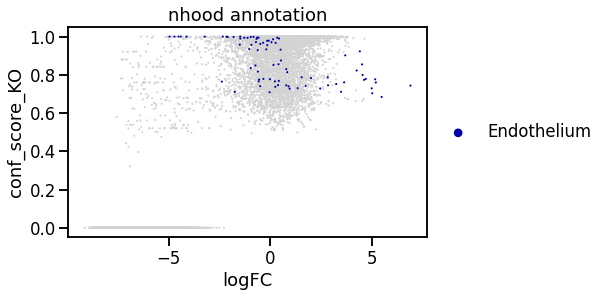

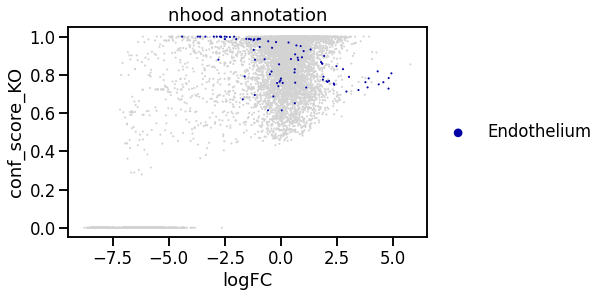

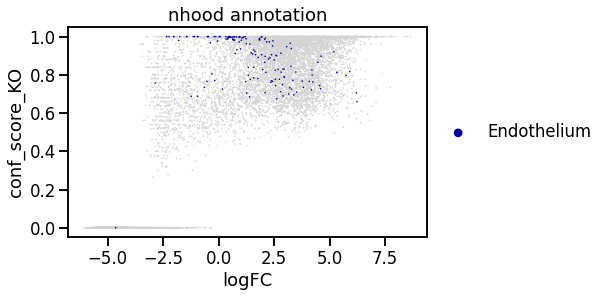

In [180]:
sc.pl.scatter(get_nhood_adata(pac_design_adata), 'logFC','conf_score_KO', color='nhood_annotation', groups='Endothelium')
sc.pl.scatter(get_nhood_adata(pc_design_adata), 'logFC','conf_score_KO', color='nhood_annotation', groups='Endothelium')
sc.pl.scatter(get_nhood_adata(pa_design_adata), 'logFC','conf_score_KO', color='nhood_annotation', groups='Endothelium')

## Detection of missing blood lineages

__Does the design sensitively detect the missing blood lineages?__ annotate neighbourhoods using the _control_ annotations (C in PAC), compute TPR for clusters annotated as   `Blood progenitors` or `Erythroid` (where positive == logFC < 0 and SpatialFDR < 0.1). Consider FP all the other predicted depletions.

In [182]:
pa_nhood_obs = get_nhood_adata(pa_design_adata).obs.copy()
pac_nhood_obs = get_nhood_adata(pac_design_adata).obs.copy()
pc_nhood_obs = get_nhood_adata(pc_design_adata).obs.copy()

pac_nhood_obs['design'] = 'PAC'
pa_nhood_obs['design'] = 'PA'
pc_nhood_obs['design'] = 'PC'

In [185]:
nhood_obs_df = pd.concat([pac_nhood_obs, pc_nhood_obs, pa_nhood_obs])

In [193]:
nhood_obs_df['is_blood'] = nhood_obs_df.nhood_annotation.isin(blood_lineages).astype('int')
nhood_obs_df['is_signif'] = ((nhood_obs_df.SpatialFDR < 0.1) & (nhood_obs_df.logFC < 0)).astype('int')

In [231]:
## Compute TPR
def _get_blood_TPR(sub_nhoods_obs_df):
    conf_mat = sc.metrics.confusion_matrix('is_blood', 'is_signif',data=sub_nhoods_obs_df, normalize=False)
    conf_mat.columns = ['pred_negative', 'pred_positive']
    conf_mat.index = ['true_negative', 'true_positive']
    tpr = conf_mat.loc['true_positive', 'pred_positive']/(conf_mat.loc['true_positive', 'pred_positive']+conf_mat.loc['true_negative', 'pred_positive'])
    tnr = conf_mat.loc['true_negative', 'pred_negative']/(conf_mat.loc['true_negative', 'pred_negative']+conf_mat.loc['true_positive', 'pred_negative'])
    return(tpr,tnr)

for d in ["PAC", "PC"]:
    tpr,tnr = _get_blood_TPR(nhood_obs_df[nhood_obs_df.design==d])
    print(f"{d} design TPR = {tpr}")
    print(f"{d} design TNR = {tnr}")

PAC design TPR = 0.8931955211024979
PAC design TNR = 0.9886765746638358
PC design TPR = 0.9053254437869822
PC design TNR = 0.9940056417489421


In [232]:
%%R -i nhood_obs_df
head(nhood_obs_df)

             index_cell kth_distance conf_score_KO
1  cell_6-Tal1Chimera-0    2.2270198     0.8493261
2  cell_7-Tal1Chimera-0    1.2323380     1.0000000
3 cell_11-Tal1Chimera-0    0.8120825     0.8935166
4 cell_24-Tal1Chimera-0    3.0808203     0.8304105
5 cell_27-Tal1Chimera-0    1.6156150     0.9857170
6 cell_29-Tal1Chimera-0    1.2040131     1.0000000
                nhood_annotation nhood_annotation_frac Nhood_size SpatialFDR
1                 Cardiomyocytes             0.9090909        132 0.62490649
2                 Cardiomyocytes             1.0000000        172 0.95790969
3                      Allantois             0.9234973        183 0.64020688
4                            Gut             0.6625000         80 0.99468255
5 Haematoendothelial progenitors             0.9828572        175 0.04896067
6                      Allantois             1.0000000        178 0.37231304
        logFC   logCPM           F     PValue        FDR design is_blood
1  1.13527589 7.008077 0.963662

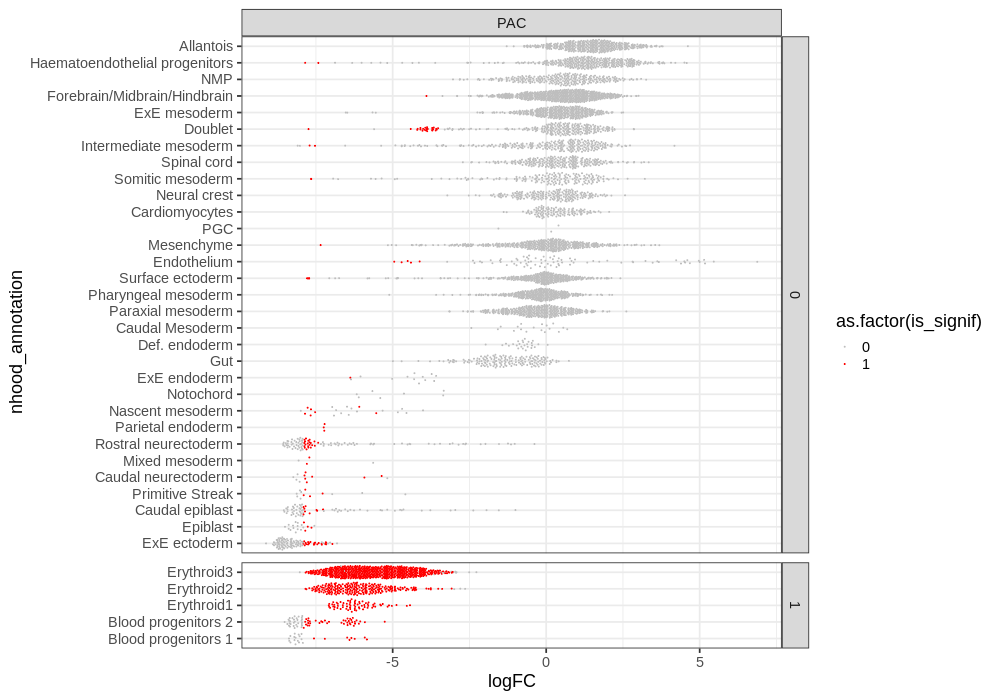

In [997]:
%%R -w 1000 -h 700

nhood_obs_df %>%
    filter(!is.na(nhood_annotation)) %>%
    filter(design=='PAC') %>%
    group_by(nhood_annotation) %>%
    mutate(logFC_median = median(logFC)) %>%
    ungroup() %>%
    arrange(logFC_median) %>%
    mutate(nhood_annotation = factor(nhood_annotation, levels=unique(nhood_annotation))) %>%
    ggplot(aes(nhood_annotation, logFC)) +
    ggbeeswarm::geom_quasirandom(size=0.3, aes(color=as.factor(is_signif))) +
#     geom_histogram(data=. %>% filter(is_blood==1), fill='red') +
    facet_grid(is_blood~design, scales='free', space='free') +
    scale_color_manual(values=c(`0`='grey', `1`='red')) +
    coord_flip() +
    theme_bw(base_size=18)

In [1007]:
get_nhood_adata(pac_design_adata).obs = pac_nhood_obs.copy()

## Detection of transformed endothelium 
__Does the design detect the Tal1-/- specific endothelium?__ 
- sort neighbourhoods that contain at least 1 KO cell by uncertainty score, in which rank are the endothelium neighbourhoods?  
- 

In [266]:
# nhood_obs_df['conf_score_KO_rank'] = nhood_obs_df.groupby('design')['conf_score_KO'].rank()

In [268]:
%%R -i nhood_obs_df
dim(nhood_obs_df)

[1] 25558    16


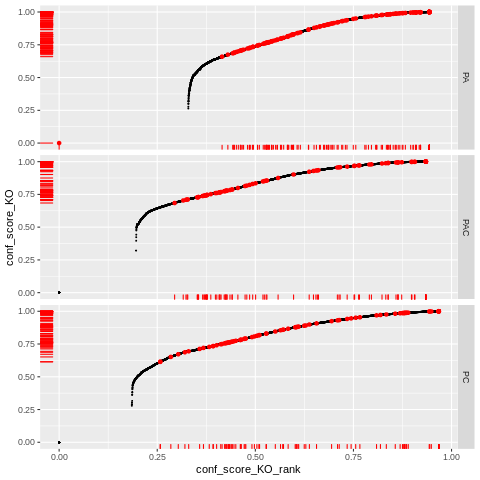

In [276]:
%%R
nhood_obs_df %>%
group_by(design) %>%
mutate(conf_score_KO_rank = percent_rank(conf_score_KO)) %>%
ungroup() %>%
ggplot(aes(conf_score_KO_rank, conf_score_KO)) +
geom_point(size=0.3) +
geom_point(data=. %>% filter(nhood_annotation=='Endothelium'), color='red') +
geom_rug(data=. %>% filter(nhood_annotation=='Endothelium'), color='red') +
facet_grid(design~.)

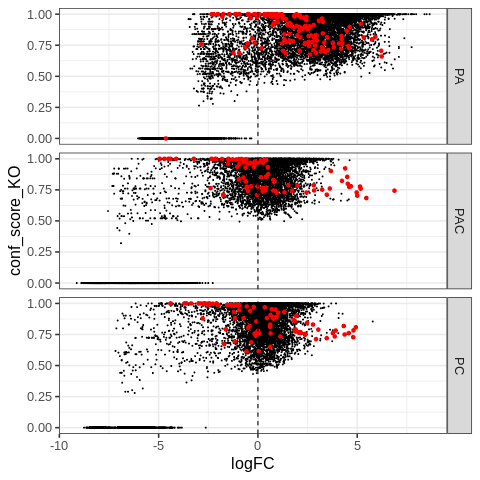

In [280]:
%%R
nhood_obs_df %>%
ggplot(aes(logFC, conf_score_KO)) +
geom_point(size=0.3) +
geom_point(data=. %>% filter(nhood_annotation=='Endothelium'), color='red') +
facet_grid(design~.) +
geom_vline(xintercept=0, linetype=2) +
theme_bw(base_size=16)

In [394]:
pac_design_adata.obs['is_KO'] = pac_design_adata.obs['design'] == 'Tal1Chimera_tomatoP'
pac_design_adata.obs['is_KO'] = ['WT' if not x else 'KO' for x in pac_design_adata.obs['is_KO']]
pac_design_adata.obs['is_KO'].value_counts()

WT    58520
KO    28305
Name: is_KO, dtype: int64

In [896]:
## Differential uncertainty
diff2atlas.nhood_confidence(pac_design_adata, confidence_col='conf_score', sample_col='sample', impute_missing=False)
diff2atlas.make_design(pac_design_adata, categorical_covariates=['design', 'is_KO'])

In [774]:
def highly_variable_nhoods(adata):
    '''
    Find neighbourhoods with highly variable confidence scores

    Params:
    ------
    - adata: AnnData object

    Returns:
    -------
    None, adds in place adata.uns['nhood_adata'].obs['highly_variable']
    '''
    try:
        nhood_adata = adata.uns['nhood_adata'].copy()
    except:
        raise ValueError(
            "adata.uns['nhood_adata'] not found -- please run nhood_confidence first")

    try:
        confidence_mat = nhood_adata.layers['confidence'].copy()
    except:
        raise ValueError(
            "adata.uns['nhood_adata'].layers['confidence'] not found -- please run nhood_confidence first")

    nhood_conf_var = np.nanvar(nhood_adata.layers['confidence'], axis=1)
    nhood_conf_mean = np.nanmean(nhood_adata.layers['confidence'], axis=1)

    lowess = sm.nonparametric.lowess
    z = lowess(nhood_conf_var, nhood_conf_mean)
    # Keep neighbourhoods with std higher than expected by the mean
    nhood_adata.obs['confidence_mean'] = nhood_conf_mean
    nhood_adata.obs['confidence_var'] = nhood_conf_var
    nhood_adata.obsm['confidence_var_lowess'] = z
    nhood_adata.obs['highly_variable'] = nhood_conf_var > z[:, 1]
    adata.uns['nhood_adata'] = nhood_adata.copy()

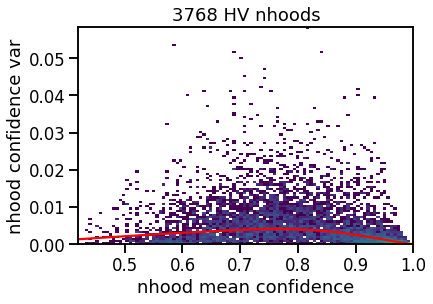

In [781]:
diff2atlas.plotting.highly_variable_nhoods(pac_design_adata)

In [943]:
import diff2atlas

In [944]:
pac_design_adata.obs['dataset_test'] = [x[0] for x in pac_design_adata.obs['design'].str.split('_')]
diff2atlas.make_design(pac_design_adata, categorical_covariates=['design', 'is_KO','dataset_test'])

In [979]:
pac_design_adata.uns['nhood_adata'] = pac_design_adata.uns['nhood_adata'][:,pac_design_adata.uns['nhood_adata'].var_names.str.startswith('Tal1')].copy()

In [991]:
pac_design_adata.uns['nhood_adata'] = pac_design_adata.uns['nhood_adata'][np.isnan(pac_design_adata.uns['nhood_adata'].layers['confidence']).sum(1) < 4].copy()

In [992]:
diff2atlas.test_confidence(pac_design_adata, test_covariate='is_KO', method='OLS', ref_level='WT', use_highly_variable=True)

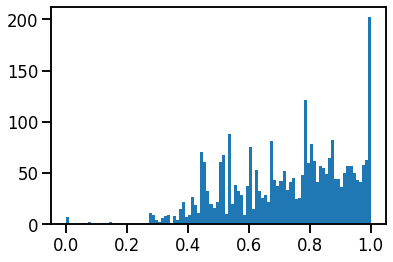

In [994]:
plt.hist(get_nhood_adata(pac_design_adata).obs['confidence_test_adj_pvals'], bins=100);

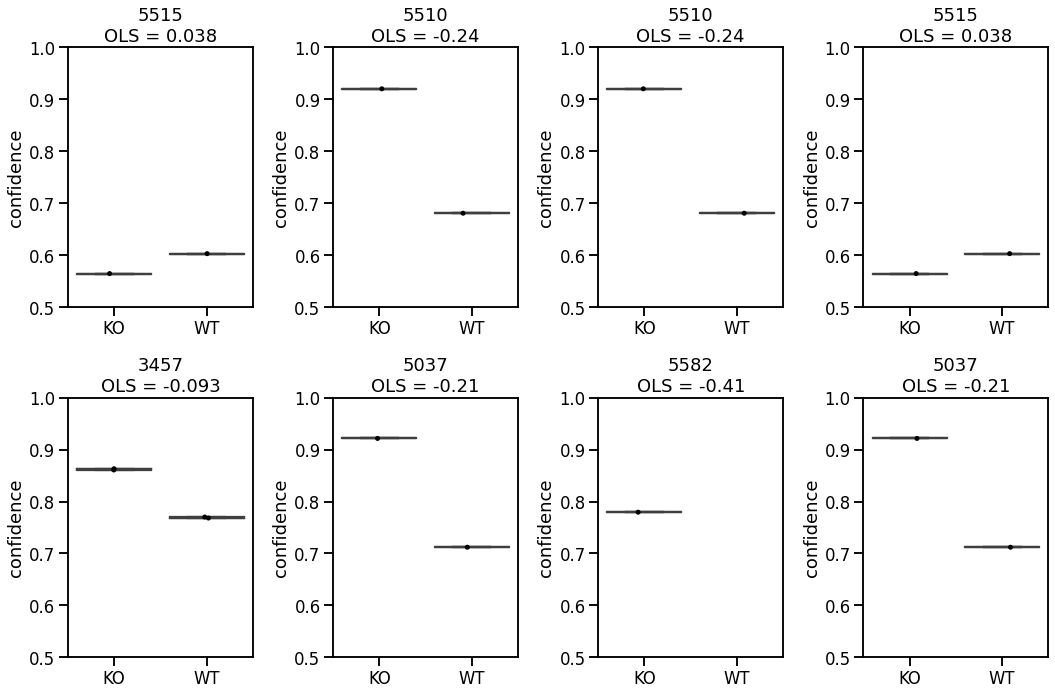

In [996]:
obs = get_nhood_adata(pac_design_adata).obs_names[get_nhood_adata(pac_design_adata).obs['confidence_test_adj_pvals'] < 0.1]
# pac_design_adata.uns['nhood_adata'].var['dataset_test'] = pac_design_adata.uns['nhood_adata'].var['dataset_test'].astype('category')

with rc_context({'figure.figsize': (15, 10)}):
    diff2atlas.plotting.plot_nhood_confidence_boxplot(pac_design_adata, obs_names = np.random.choice(obs, 8), n_cols=4, ylim=[0.5, 1])

In [970]:
get_nhood_adata(pac_design_adata).obs[['highly_variable', 'confidence_test_statistic']] 

highly_variable  confidence_test_statistic
0                True                   0.059456
1               False                   0.000000
2                True                  -0.011261
3                True                  -0.067714
4                True                  -0.020673
...               ...                        ...
6808             True                        NaN
6809             True                   0.085764
6810             True                   0.034802
6811             True                  -0.056650
6812             True                        NaN

[6813 rows x 2 columns]

In [891]:
alpha = 0.1
nhood_adata = get_nhood_adata(pac_design_adata).copy()
nhood_adata.obs['confidence_test_statistic_plot'] = np.nan
nhood_adata.obs['confidence_test_statistic_plot'] = (-nhood_adata.obs['confidence_test_statistic']).copy()
nhood_adata.obs.loc[nhood_adata.obs['confidence_test_adj_pvals'] > alpha, 'confidence_test_statistic_plot'] = np.nan
pac_design_adata.uns['nhood_adata'] = nhood_adata.copy()

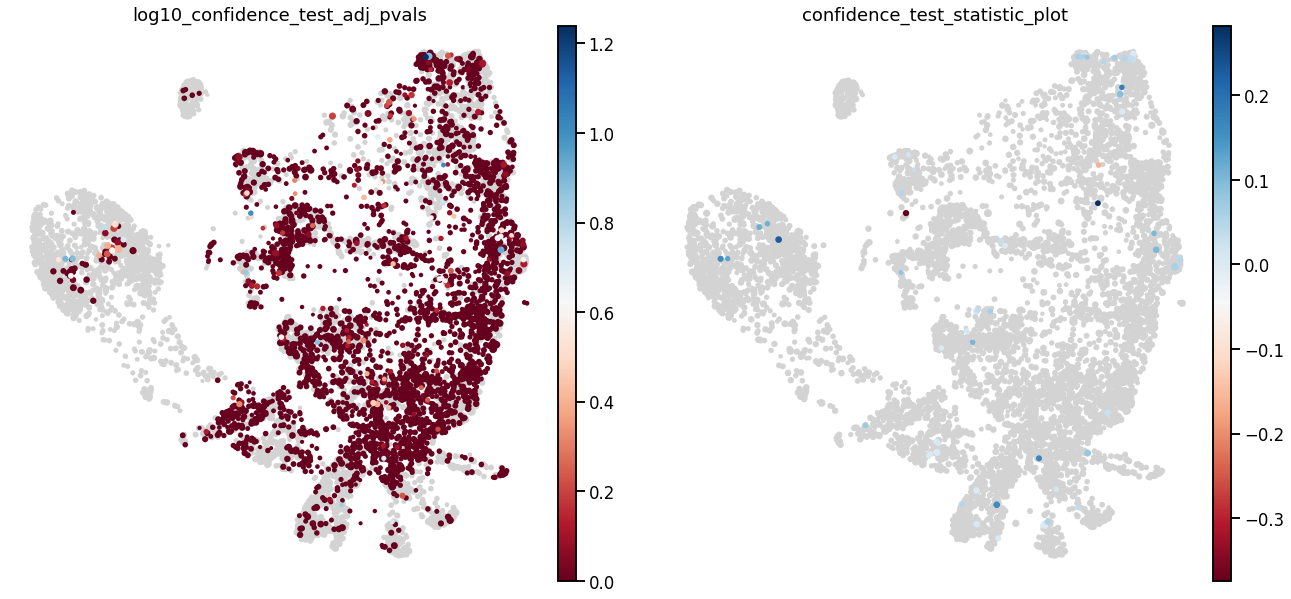

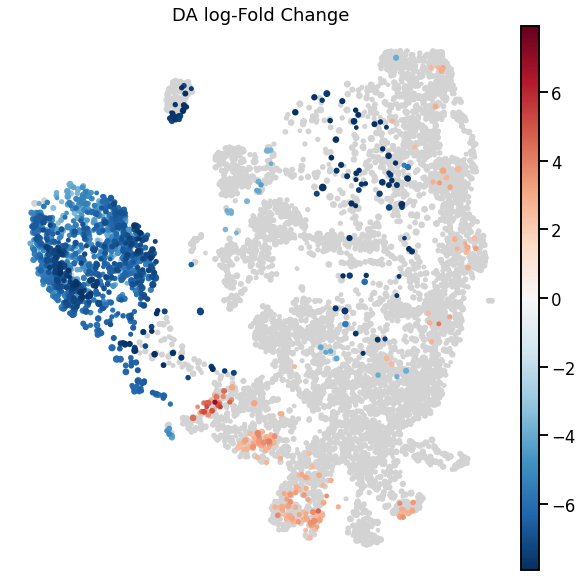

In [892]:
with rc_context({'figure.figsize':[10,10]}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata, min_size=1, color=['log10_confidence_test_adj_pvals', 'confidence_test_statistic_plot'], cmap='RdBu')
    milopy.plot.plot_nhood_graph(pac_design_adata, min_size=1)

In [685]:
from sklearn.linear_model import LinearRegression
nhood_adata = get_nhood_adata(pac_design_adata).copy()
confidence_mat = nhood_adata.layers['confidence'][6630:6640,].copy()
nhood_confidence = nhood_adata.layers['confidence'][6630,:]
test_vec = nhood_adata.varm['design_matrix']['is_KO_KO'].values

def _nhood_OLS(test_vec, nhood_confidence):
    '''Compute OLS regression for single neighbourhood'''
    nan_mask = ~np.isnan(nhood_confidence)
    y = nhood_confidence[nan_mask]
    X = test_vec[nan_mask]
    # X = test_vec[nan_mask].reshape(-1, 1)
    coef, _, _, pval, _ = stats.linregress(X, y)
    # ols = LinearRegression().fit(X, y)
    # coef = ols.coef_[0]
    # X = sm.add_constant(X)
    # pval = sm.OLS(y, X).fit().summary2().tables[1]['P>|t|'][0]
    return(coef, pval)

In [686]:
coef, _, _,pval, _ = stats.linregress(X.flatten(), y)

In [688]:
outs = np.apply_along_axis(
            lambda x: _nhood_OLS(test_vec, x), 1, confidence_mat)        

In [690]:
help(stats.linregress)

Help on function linregress in module scipy.stats._stats_mstats_common:

linregress(x, y=None)
    Calculate a linear least-squares regression for two sets of measurements.
    
    Parameters
    ----------
    x, y : array_like
        Two sets of measurements.  Both arrays should have the same length.  If
        only `x` is given (and ``y=None``), then it must be a two-dimensional
        array where one dimension has length 2.  The two sets of measurements
        are then found by splitting the array along the length-2 dimension.  In
        the case where ``y=None`` and `x` is a 2x2 array, ``linregress(x)`` is
        equivalent to ``linregress(x[0], x[1])``.
    
    Returns
    -------
    slope : float
        Slope of the regression line.
    intercept : float
        Intercept of the regression line.
    rvalue : float
        Correlation coefficient.
    pvalue : float
        Two-sided p-value for a hypothesis test whose null hypothesis is
        that the slope is zero, 

array([-0.03836642])

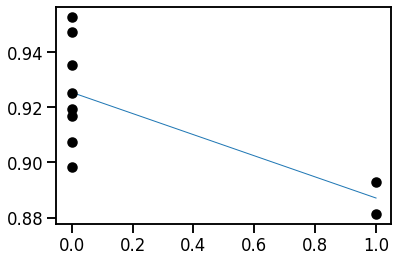

In [552]:
# and plot the result
X_test = np.linspace(0, 1, 300)
plt.scatter(X.ravel(), y, color="black", zorder=20)
ols = sklearn.linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
ols.coef_

---

## Design comparison
For all objects I need a nhood-wise statistic for query-specific population detection (i.e. uncertainty or differential uncertainty test)
- PA: P cell uncertainty
- PC: P cell uncertainty 
- PAC: differential uncertainty measure per neighbourhood of each P cell

To make it comparable I can make one neighbourhood for each Tal1-/- cell (and select a subset for speed?)

In [11]:
def _make_cell_nhoods(adata, obs_ixs, neighbors_key=None):
    '''Get neighbourhoods of a specific set of cells'''
    if neighbors_key is None:
        try:
            use_rep = adata.uns["neighbors"]["params"]["use_rep"]
        except KeyError:
            logging.warning('Using X_pca as default embedding') 
            use_rep = "X_pca"
        try:
            knn_graph = adata.obsp["connectivities"].copy()
        except KeyError:
            raise KeyError(
                'No "connectivities" slot in adata.obsp -- please run scanpy.pp.neighbors(adata) first'
            )
    else:
        use_rep = adata.uns[neighbors_key]["params"]["use_rep"]
        knn_graph = adata.obsp[neighbors_key + "_connectivities"].copy()
    
    ## Binarize
    knn_graph[knn_graph!=0] = 1    
    nhoods = knn_graph[:,obs_ixs]
    adata.obsm['cell_nhoods'] = nhoods
    
    

In [61]:
sc.tl.umap(pac_design_adata_q)

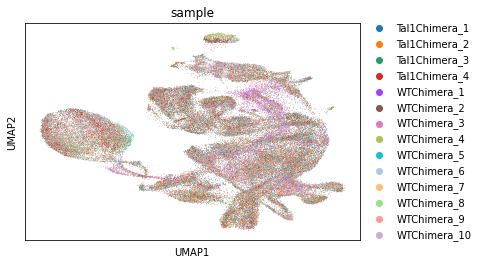

In [64]:
sc.pl.umap(pac_design_adata_q, color='sample')

In [13]:
_rename_design(pac_design_adata_q)
ko_obs_ixs = np.where(pac_design_adata_q.obs['design'] == 'Tal1Chimera_tomatoP')[0]

## selecting subset of cells
ko_obs_ixs_smp = np.random.choice(ko_obs_ixs, 5000)
ko_obs_smp = pac_design_adata_q.obs_names[ko_obs_ixs_smp] ## Store for other designs

_make_cell_nhoods(pac_design_adata_q, ko_obs_ixs_smp) 

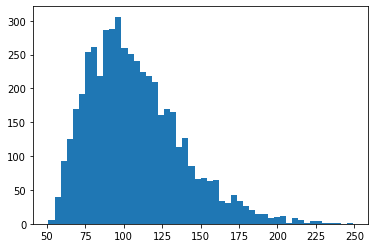

In [21]:
plt.hist(np.array(pac_design_adata_q.obsm['cell_nhoods'].sum(0)).ravel(), bins=50);

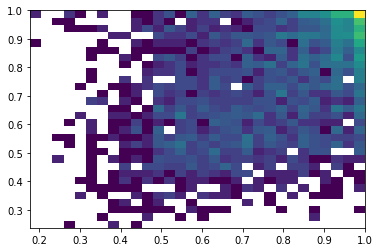

In [22]:
plt.hist2d(pa_design_adata[ko_obs_smp.str.strip('-0')].obs['scArches_unc'], 
        pc_design_adata[ko_obs_smp.str.strip('-0')].obs['scArches_unc'], 
           bins=30, norm=matplotlib.colors.LogNorm());

## Differential uncertainty comparison - scArches uncertainty

In [16]:
## Turn to confidence
pac_design_adata_q.obs['scArches_unc'] = 1 - pac_design_adata_q.obs['scArches_unc']
pc_design_adata.obs['scArches_unc'] = 1 - pc_design_adata.obs['scArches_unc']
pa_design_adata.obs['scArches_unc'] = 1 - pa_design_adata.obs['scArches_unc']

In [17]:
import diff2atlas

In [18]:
## Compute differential unc
diff2atlas.nhood_confidence(pac_design_adata_q, confidence_col='scArches_unc', sample_col='sample')
diff2atlas.make_design(pac_design_adata_q, categorical_covariates=['design'])
diff2atlas.test_confidence(pac_design_adata_q, test_covariate='design', method='t-test', ref_level='Tal1Chimera_tomatoP')

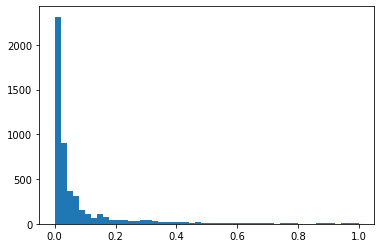

In [23]:
plt.hist(pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_pvals'], bins=50);

In [26]:
obs = pac_design_adata_q.uns['nhood_adata'].obs_names[pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_statistic'] >= 1]
# pac_design_adata_q.uns['nhood_adata'].var['design'] = pac_design_adata_q.uns['nhood_adata'].var['design'].astype('category')

with rc_context({'figure.figsize': (12, 4)}):
    diff2atlas.plotting.plot_nhood_confidence_boxplot(pac_design_adata_q, obs_names = obs[0:8], n_cols=4)

In [27]:
nhood_adata = pac_design_adata_q.uns['nhood_adata'].copy()
cell_abundance_mask = nhood_adata.X.toarray() > 0 

In [30]:
nhood_adata.layers['confidence'][cell_abundance_mask]

array([0.92919248, 0.82235471, 0.90737674, ..., 0.61792609, 0.80101277,
       0.84030071])

<AxesSubplot:>

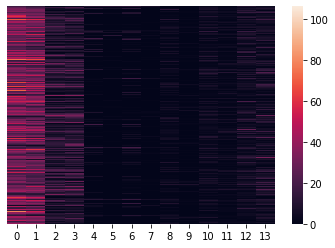

In [28]:
sns.heatmap(nhood_adata.X.toarray(), xticklabels=True, yticklabels=False)

In [31]:
from milopy.core import make_nhoods
make_nhoods(pac_design_adata_q, prop=0.1)

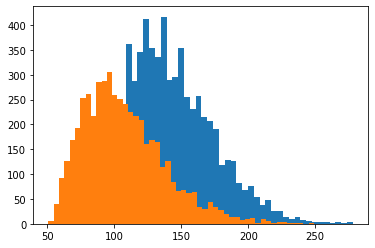

In [33]:
plt.hist(np.array(pac_design_adata_q.obsm['nhoods'].sum(0)).ravel(), bins=50);
plt.hist(np.array(pac_design_adata_q.obsm['cell_nhoods'].sum(0)).ravel(), bins=50);

In [34]:
pac_design_adata_q.obsm['cell_nhoods'] = pac_design_adata_q.obsm['nhoods'].copy()

In [42]:
## Compute differential unc
diff2atlas.nhood_confidence(pac_design_adata_q, confidence_col='scArches_unc', sample_col='sample')
diff2atlas.make_design(pac_design_adata_q, categorical_covariates=['design'])
diff2atlas.test_confidence(pac_design_adata_q, test_covariate='design', method='t-test', ref_level='Tal1Chimera_tomatoP')

In [51]:
sum(pac_design_adata_q.uns['nhood_adata'].X.toarray() == 0, 1)

array([1385, 1427,  410,  362, 4347, 5051, 4432, 4799, 1954, 3196,  895,
       1075,  425,  192])

<AxesSubplot:>

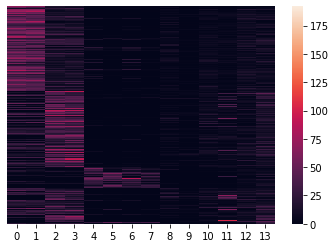

In [53]:
sns.heatmap(pac_design_adata_q.uns['nhood_adata'].X.toarray(), xticklabels=True, yticklabels=False)

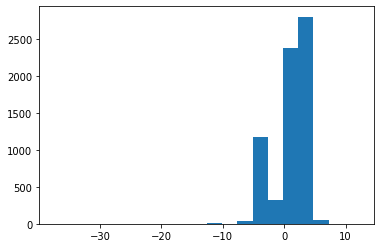

In [156]:
plt.hist(pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_statistic'], bins=20);

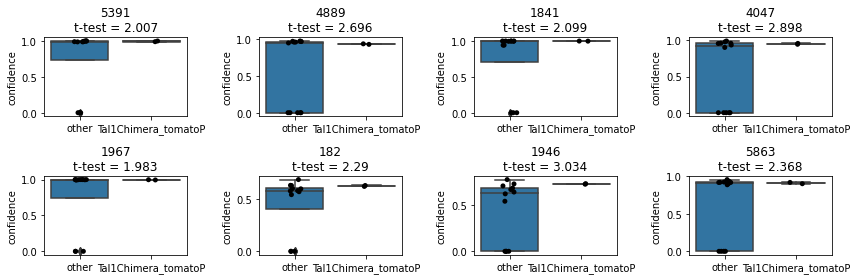

In [157]:
obs = pac_design_adata_q.uns['nhood_adata'].obs_names[pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_statistic'] > 0.9]
# pac_design_adata_q.uns['nhood_adata'].var['design'] = pac_design_adata_q.uns['nhood_adata'].var['design'].astype('category')

with rc_context({'figure.figsize': (12, 4)}):
    diff2atlas.plotting.plot_nhood_confidence_boxplot(pac_design_adata_q, obs_names = np.random.choice(obs, 8), n_cols=4)

In [96]:
import diff2atlas

In [158]:
## Add uncertainty from other designs 
pac_design_adata_q.obs['PA_conf'] = np.nan
pac_design_adata_q.obs.loc[ko_obs_smp, 'PA_conf'] = pa_design_adata[ko_obs_smp.str.strip('-0')].obs['scArches_unc'].values
pac_design_adata_q.obs['PC_conf'] = np.nan
pac_design_adata_q.obs.loc[ko_obs_smp, 'PC_conf'] = pc_design_adata[ko_obs_smp.str.strip('-0')].obs['scArches_unc'].values

## Calculate mean uncertainty for KO cells in nhoods 
nhood_mat = pac_design_adata_q[ko_obs_smp].obsm['nhoods']
PA_conf_nhoods = nhood_mat.T.dot(
        scipy.sparse.csr_matrix(pac_design_adata_q.obs.loc[ko_obs_smp, 'PA_conf']).T)
PA_conf_nhoods = PA_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
PA_conf_nhoods = np.nan_to_num(PA_conf_nhoods, 0) ## zero confidence where we have no cells
PC_conf_nhoods = nhood_mat.T.dot(
        scipy.sparse.csr_matrix(pac_design_adata_q.obs.loc[ko_obs_smp, 'PC_conf']).T)
PC_conf_nhoods = PC_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
PC_conf_nhoods = np.nan_to_num(PC_conf_nhoods, 0) ## zero confidence where we have no cells

## Add to nhood_adata
pac_design_adata_q.uns['nhood_adata'].obs['mean_PA_conf'] = PA_conf_nhoods
pac_design_adata_q.uns['nhood_adata'].obs['mean_PC_conf'] = PC_conf_nhoods

In [171]:
pac_design_adata_q.uns['nhood_adata'].obs['FDR'] = - np.log10(pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_adj_pvals'])
pac_design_adata_q.uns['nhood_adata'].obs.loc[pac_design_adata_q.uns['nhood_adata'].obs['FDR'] > 3, 'FDR'] = 3.0

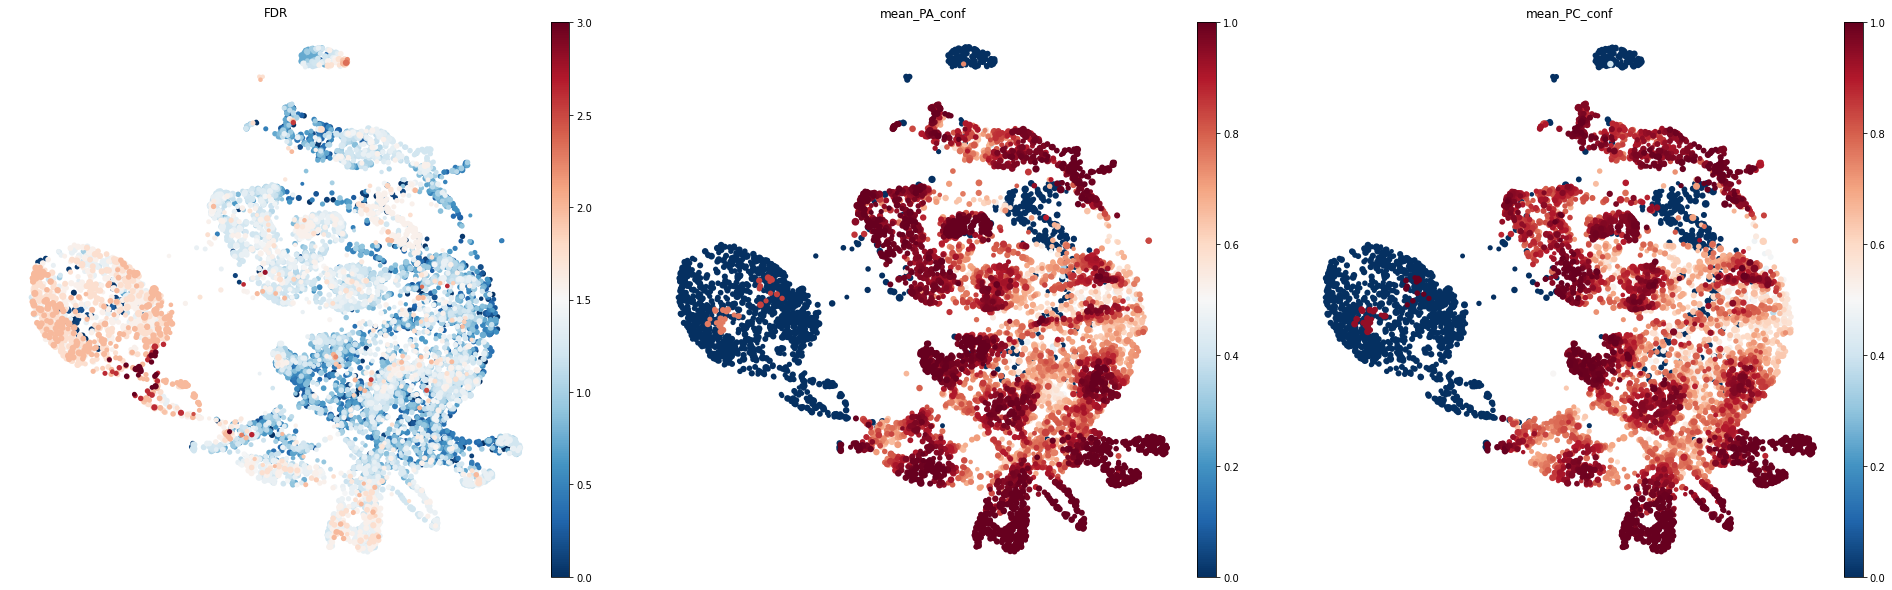

In [173]:
with rc_context({'figure.figsize': (10, 10)}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata_q, plot_edges=False, min_size=1, color=['FDR', "mean_PA_conf", 'mean_PC_conf'], cmap='RdBu_r')


In [174]:
nhood_adata = pac_design_adata_q.uns['nhood_adata'].copy()

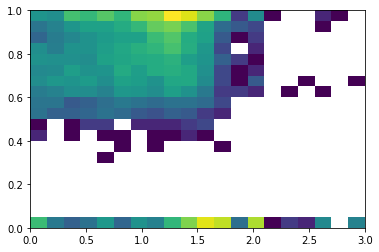

In [176]:
plt.hist2d(nhood_adata.obs['FDR'],
nhood_adata.obs['mean_PA_conf'],
norm=matplotlib.colors.LogNorm(), bins=20);

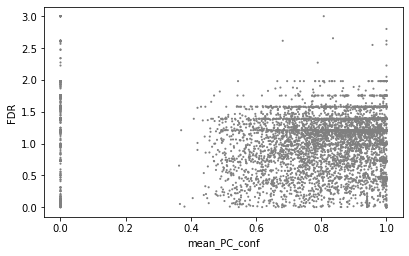

In [178]:
sc.pl.scatter(nhood_adata, 'mean_PC_conf', 'FDR')

Try scaling uncertainty

In [194]:
import sklearn
pac_design_adata.obs['scaled_scArches_unc'] = sklearn.preprocessing.minmax_scale(pac_design_adata.obs['scArches_unc'])
pac_design_adata_q.obs['scaled_scArches_unc'] = sklearn.preprocessing.minmax_scale(pac_design_adata_q.obs['scArches_unc'])
pc_design_adata.obs['scaled_scArches_unc'] = sklearn.preprocessing.minmax_scale(pc_design_adata.obs['scArches_unc'])
pa_design_adata.obs['scaled_scArches_unc'] = sklearn.preprocessing.minmax_scale(pa_design_adata.obs['scArches_unc'])

In [201]:
## Compute differential unc
diff2atlas.nhood_confidence(pac_design_adata_q, confidence_col='scaled_scArches_unc', sample_col='sample')
diff2atlas.make_design(pac_design_adata_q, categorical_covariates=['design'])
diff2atlas.test_confidence(pac_design_adata_q, test_covariate='design', method='AUROC', ref_level='Tal1Chimera_tomatoP')

## Add uncertainty from other designs 
pac_design_adata_q.obs['PA_conf'] = np.nan
pac_design_adata_q.obs.loc[ko_obs_smp, 'PA_conf'] = pa_design_adata[ko_obs_smp.str.strip('-0')].obs['scaled_scArches_unc'].values
pac_design_adata_q.obs['PC_conf'] = np.nan
pac_design_adata_q.obs.loc[ko_obs_smp, 'PC_conf'] = pc_design_adata[ko_obs_smp.str.strip('-0')].obs['scaled_scArches_unc'].values

## Calculate mean uncertainty for KO cells in nhoods 
nhood_mat = pac_design_adata_q[ko_obs_smp].obsm['nhoods']
PA_conf_nhoods = nhood_mat.T.dot(
        scipy.sparse.csr_matrix(pac_design_adata_q.obs.loc[ko_obs_smp, 'PA_conf']).T)
PA_conf_nhoods = PA_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
PA_conf_nhoods = np.nan_to_num(PA_conf_nhoods, 0) ## zero confidence where we have no cells
PC_conf_nhoods = nhood_mat.T.dot(
        scipy.sparse.csr_matrix(pac_design_adata_q.obs.loc[ko_obs_smp, 'PC_conf']).T)
PC_conf_nhoods = PC_conf_nhoods.toarray()/np.array(nhood_mat.T.sum(1))
PC_conf_nhoods = np.nan_to_num(PC_conf_nhoods, 0) ## zero confidence where we have no cells

## Add to nhood_adata
pac_design_adata_q.uns['nhood_adata'].obs['mean_PA_conf'] = PA_conf_nhoods
pac_design_adata_q.uns['nhood_adata'].obs['mean_PC_conf'] = PC_conf_nhoods


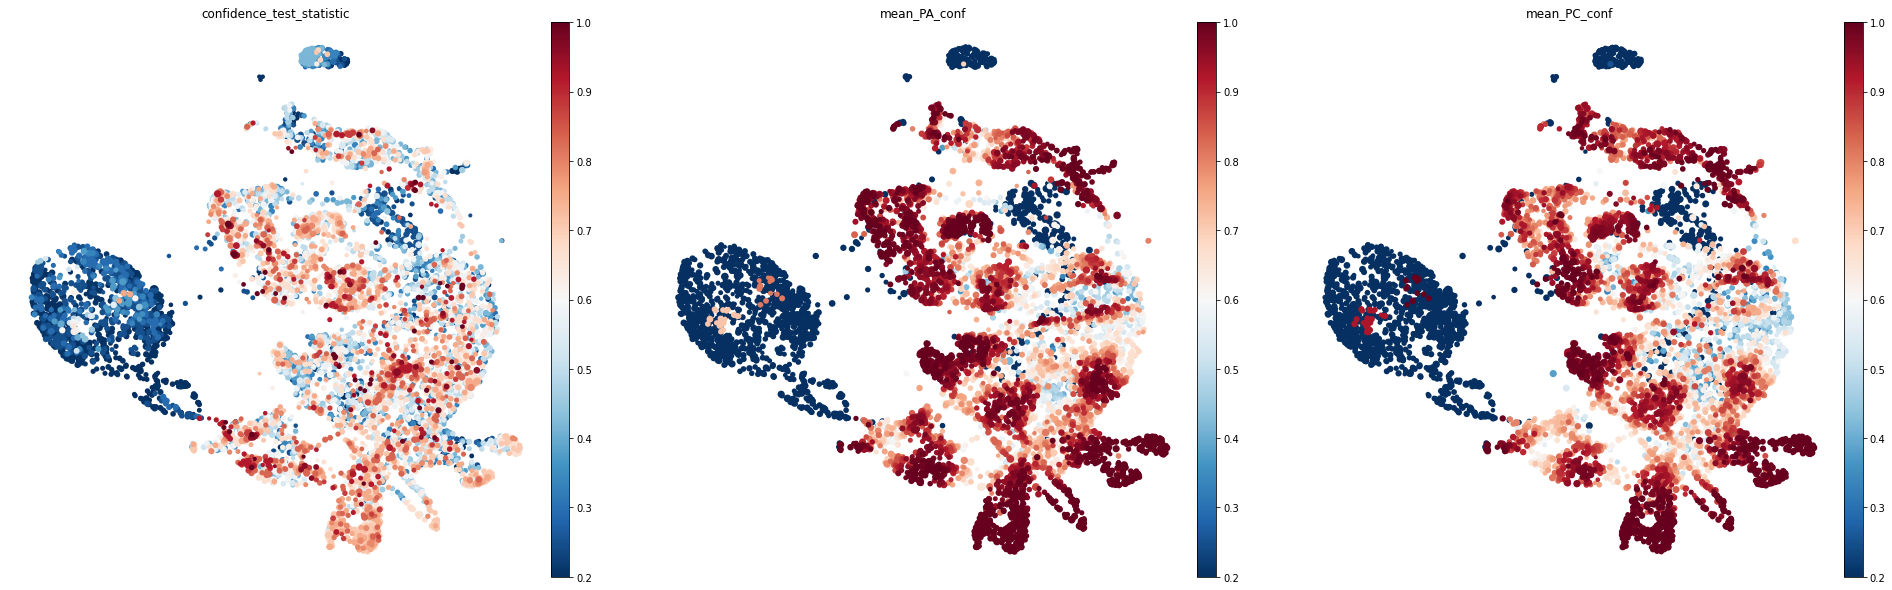

In [206]:
with rc_context({'figure.figsize': (10, 10)}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata_q, plot_edges=False, min_size=1, color=['confidence_test_statistic', "mean_PA_conf", 'mean_PC_conf'], cmap='RdBu_r', vmin=0.2)

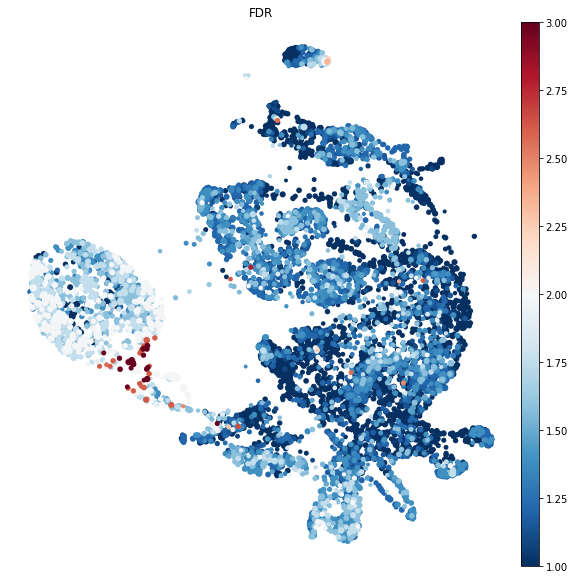

In [288]:
pac_design_adata_q.uns['nhood_adata'].obs['conf_stat_plot'] = - pac_design_adata_q.uns['nhood_adata'].obs['confidence_test_statistic']
with rc_context({'figure.figsize': (10, 10)}):
    diff2atlas.plotting.plot_nhood_graph(pac_design_adata_q, plot_edges=False, min_size=1, color=['FDR'], cmap='RdBu_r')

In [94]:
nhood_adata.obsm['X_nhood_graph'] = np.array(nhood_adata.obsm['X_nhood_graph'])

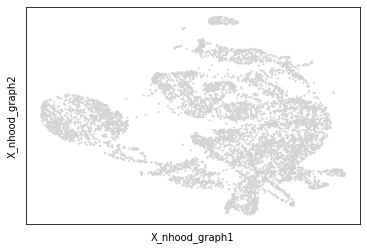

In [95]:
min_size=5
plot_edges=False
sc.pl.embedding(nhood_adata, "X_nhood_graph",
#                     size=pac_design_adata_q.uns["nhood_adata"].obs["Nhood_size"]*min_size,
#                     edges=plot_edges, neighbors_key="nhood",
#                     frameon=False
                    )

- Use DA for missing states: check celltype of logFC < 0 (is it blood lineage?), check stage for logFC > 0  
- use mean uncertainty for KO cells in the PAC design (but ignoring C), as proxy for PA design

### Comparison vs PA design
- DA test will have false positives in depletion due to different underlying distribution of celltypes being different 
- Uncertainty will be potentially driven by technical differences between datasets - we can test this on the control: we will have high uncertainty states just because of differences between celltype capturing by the model   

In [226]:
unc_df = pac_design_adata_q.obs[['scArches_unc', 'design', 'sample', 'celltype.mapped']] 

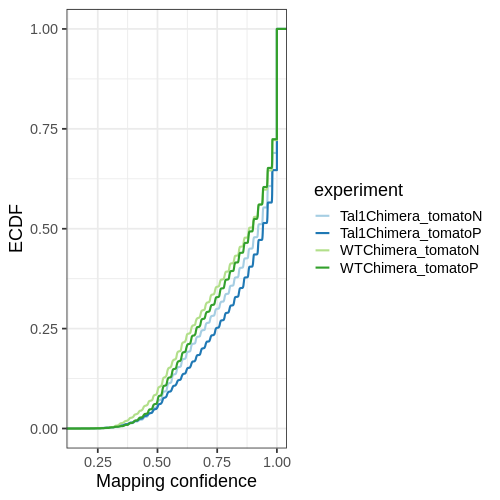

In [257]:
%%R -w 500 -h 500 -i unc_df
library(tidyverse)
library(patchwork)

unc_df %>%
    ggplot(aes(scArches_unc, color=as.factor(design))) +
    stat_ecdf(size=1) +
    theme_bw(base_size=18) +
    scale_color_brewer(palette='Paired', name='experiment') +
    ylab('ECDF') + xlab("Mapping confidence") 
    

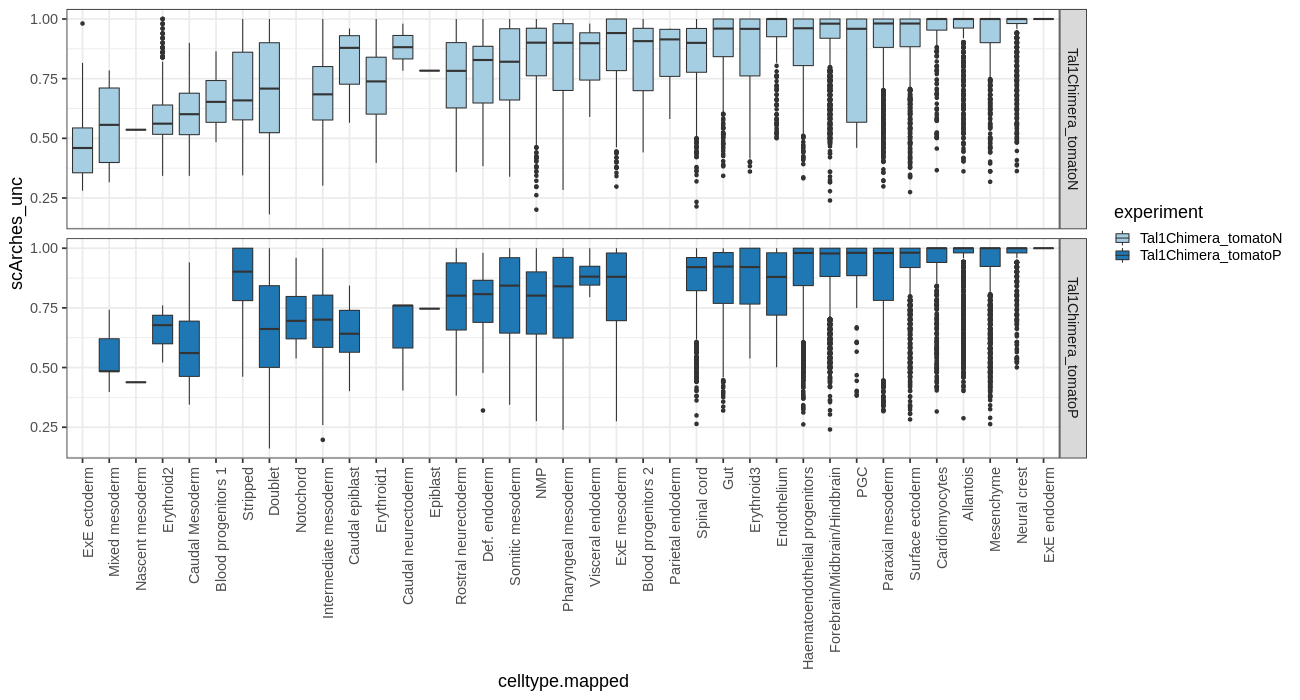

In [260]:
%%R -w 1300 -h 700 
library(tidyverse)
library(patchwork)

unc_df %>%
    filter(str_detect(design, 'Tal1')) %>%
    group_by(celltype.mapped) %>%
    mutate(med = median(scArches_unc)) %>%
    ungroup() %>%
    arrange(med) %>%
    mutate(celltype.mapped = factor(celltype.mapped, levels=unique(celltype.mapped))) %>%
    ggplot(aes(celltype.mapped, scArches_unc, fill=as.factor(design))) +
    geom_boxplot(varwidth=FALSE) +
    theme_bw(base_size=18) +
    scale_fill_brewer(palette='Paired', name='experiment') +
    facet_grid(design~.) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=1))
    

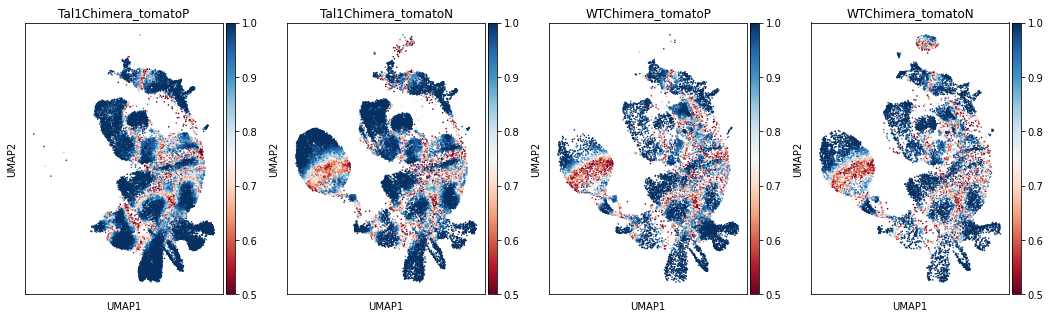

In [278]:
with rc_context({'figure.figsize': (18, 5)}):
    fig,axs = plt.subplots(1,4)
    for i,d in enumerate(pac_design_adata_q.obs['design'].unique()):
        sc.pl.umap(pac_design_adata_q[pac_design_adata_q.obs['design'] == d], 
               color='scArches_unc', cmap="RdBu", vmax=1, vmin=0.5, title=d, size=10, ax=axs[i], show=False)
    plt.show()


### Comparison vs PC design

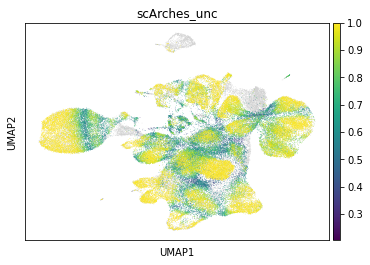

In [362]:
sc.pl.umap(pc_design_adata, color='scArches_unc')

In [375]:
unc_df = pa_design_adata.obs[['scArches_unc', 'design', 'sample', 'celltype.mapped']] 

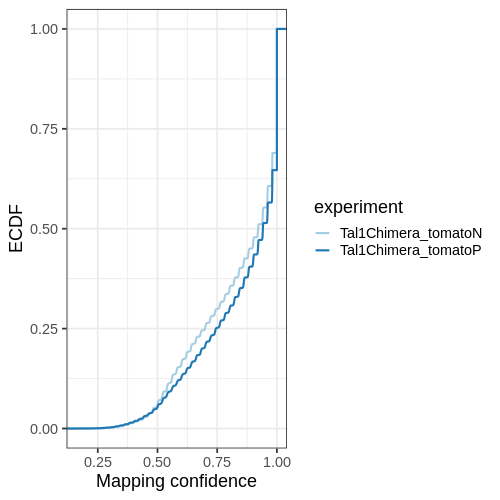

In [376]:
%%R -w 500 -h 500 -i unc_df
library(tidyverse)
library(patchwork)

unc_df %>%
    ggplot(aes(scArches_unc, color=as.factor(design))) +
    stat_ecdf(size=1) +
    theme_bw(base_size=18) +
    scale_color_brewer(palette='Paired', name='experiment') +
    ylab('ECDF') + xlab("Mapping confidence") 
    

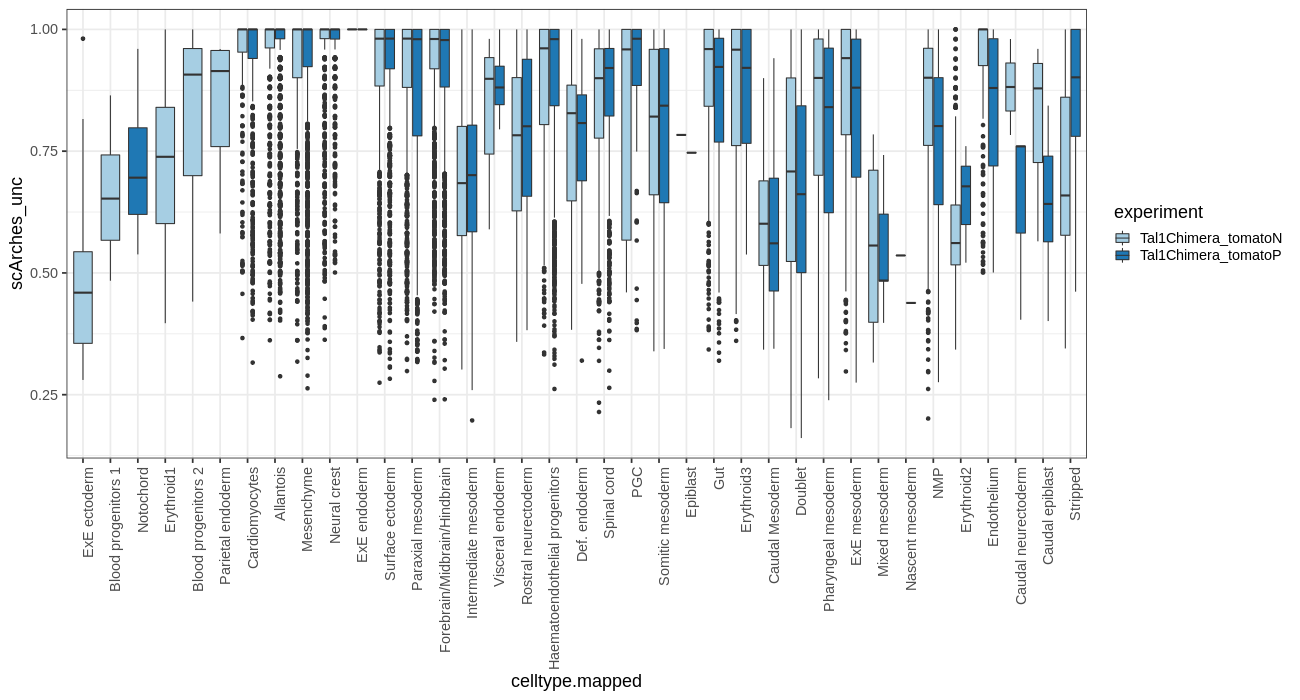

In [377]:
%%R -w 1300 -h 700 
library(tidyverse)
library(patchwork)

unc_df %>%
    filter(str_detect(design, 'Tal1')) %>%
    group_by(celltype.mapped, design) %>%
    mutate(med = median(scArches_unc)) %>%
    ungroup() %>%
    group_by(celltype.mapped) %>%
    mutate(delta_med=diff(range(med))) %>%
    ungroup() %>%
    arrange(delta_med, med) %>%
    mutate(celltype.mapped = factor(celltype.mapped, levels=unique(celltype.mapped))) %>%
    ggplot(aes(celltype.mapped, scArches_unc, fill=as.factor(design))) +
    geom_boxplot(varwidth=FALSE) +
    theme_bw(base_size=18) +
    scale_fill_brewer(palette='Paired', name='experiment') +
#     facet_grid(design~.) +
    theme(axis.text.x=element_text(angle=90, hjust=1, vjust=1))
    

In [291]:
pac_design_adata_q.obs['design']

cell_1-Tal1Chimera-0      Tal1Chimera_tomatoP
cell_2-Tal1Chimera-0      Tal1Chimera_tomatoP
cell_3-Tal1Chimera-0      Tal1Chimera_tomatoP
cell_4-Tal1Chimera-0      Tal1Chimera_tomatoP
cell_5-Tal1Chimera-0      Tal1Chimera_tomatoP
                                 ...         
cell_30699-WTChimera-1      WTChimera_tomatoN
cell_30700-WTChimera-1      WTChimera_tomatoN
cell_30701-WTChimera-1      WTChimera_tomatoN
cell_30702-WTChimera-1      WTChimera_tomatoN
cell_30703-WTChimera-1      WTChimera_tomatoN
Name: design, Length: 86825, dtype: category
Categories (4, object): ['Tal1Chimera_tomatoN', 'Tal1Chimera_tomatoP', 'WTChimera_tomatoN', 'WTChimera_tomatoP']

In [348]:
import milopy

In [349]:
milopy.core.DA_nhoods(pac_design_adata_q, 
                      design='~ design',
                      subset_samples=nhood_adata.var_names[nhood_adata.var_names.str.startswith("Tal1")])

RRuntimeError: Error in glmFit.default(y, design = design, dispersion = dispersion, offset = offset,  : 
  Design matrix not of full rank.  The following coefficients not estimable:
 3 4


'0.0.999'

In [300]:
nhood_adata.varm['design_matrix'].loc[nhood_adata.var_names[nhood_adata.var_names.str.startswith("Tal1")]]

design_Tal1Chimera_tomatoN  design_Tal1Chimera_tomatoP  \
sample                                                                  
Tal1Chimera_1                         0.0                         1.0   
Tal1Chimera_2                         0.0                         1.0   
Tal1Chimera_3                         1.0                         0.0   
Tal1Chimera_4                         1.0                         0.0   

               design_WTChimera_tomatoN  design_WTChimera_tomatoP  
sample                                                             
Tal1Chimera_1                       0.0                       0.0  
Tal1Chimera_2                       0.0                       0.0  
Tal1Chimera_3                       0.0                       0.0  
Tal1Chimera_4                       0.0                       0.0

In [303]:
design_df = nhood_adata.var['design'][nhood_adata.var_names[nhood_adata.var_names.str.startswith("Tal1")]]

In [304]:
design_df

sample
Tal1Chimera_1    Tal1Chimera_tomatoP
Tal1Chimera_2    Tal1Chimera_tomatoP
Tal1Chimera_3    Tal1Chimera_tomatoN
Tal1Chimera_4    Tal1Chimera_tomatoN
Name: design, dtype: category
Categories (4, object): ['Tal1Chimera_tomatoN', 'Tal1Chimera_tomatoP', 'WTChimera_tomatoN', 'WTChimera_tomatoP']